# **Lab 7.2 CNN**

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [62]:

def load_data(path, class_names):
	### START CODE HERE ###
	# Apply the transformations
	transform = transforms.Compose([
		transforms.Resize((28, 28)),         # Resize the image to 28x28
		transforms.ToTensor(),               # Convert the image to a tensor
	])

	dataset = ImageFolder(root=path, transform=transform)

	indices = [i for i, (_, label) in enumerate(dataset) if dataset.classes[label] in class_names]
	subset = Subset(dataset, indices)
	train_size = int(0.8 * len(subset))
	test_size = len(subset) - train_size
	train_dataset, test_dataset = random_split(subset, [train_size, test_size])
	train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
	test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
	def count_classes(dataset):
		class_counts = Counter()
		for _, label in dataset:
			class_counts[label] += 1
		return class_counts

	train_class_counts = count_classes(train_dataset)
	test_class_counts = count_classes(test_dataset)
	print("Train Dataset:")
	for cls, count in train_class_counts.items():
		print(f"Number of images in class {cls}: {count}")
	print(f"Number of training samples: {len(train_dataset)}")

	print("\nTest Dataset:")
	for cls, count in test_class_counts.items():
		print(f"Number of images in class {cls}: {count}")
	print(f"Number of testing samples: {len(test_dataset)}")

	### END CODE HERE ###
	
	return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


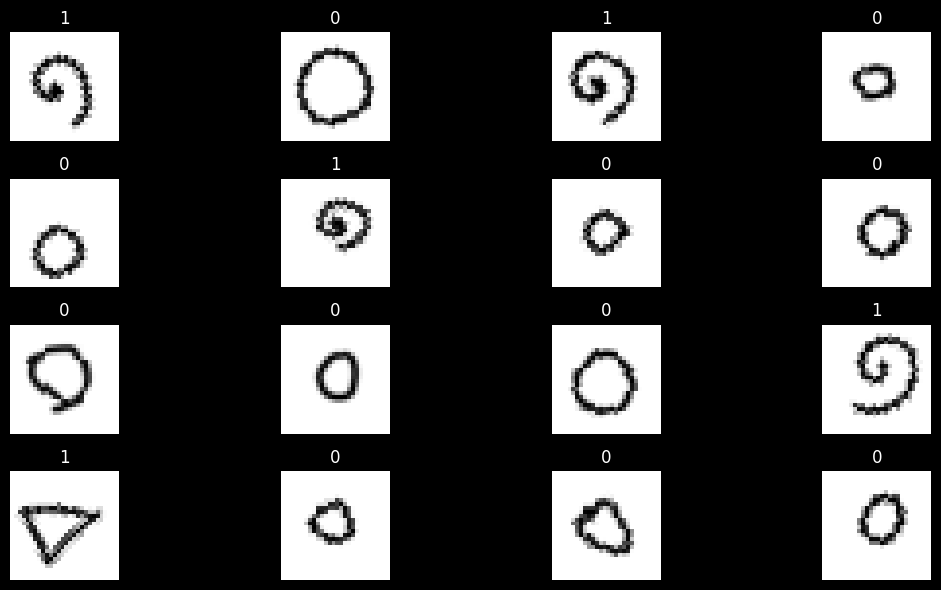

</details>

Train Dataset:
Number of images in class 0: 301
Number of images in class 1: 320
Number of training samples: 621

Test Dataset:
Number of images in class 0: 87
Number of images in class 1: 69
Number of testing samples: 156


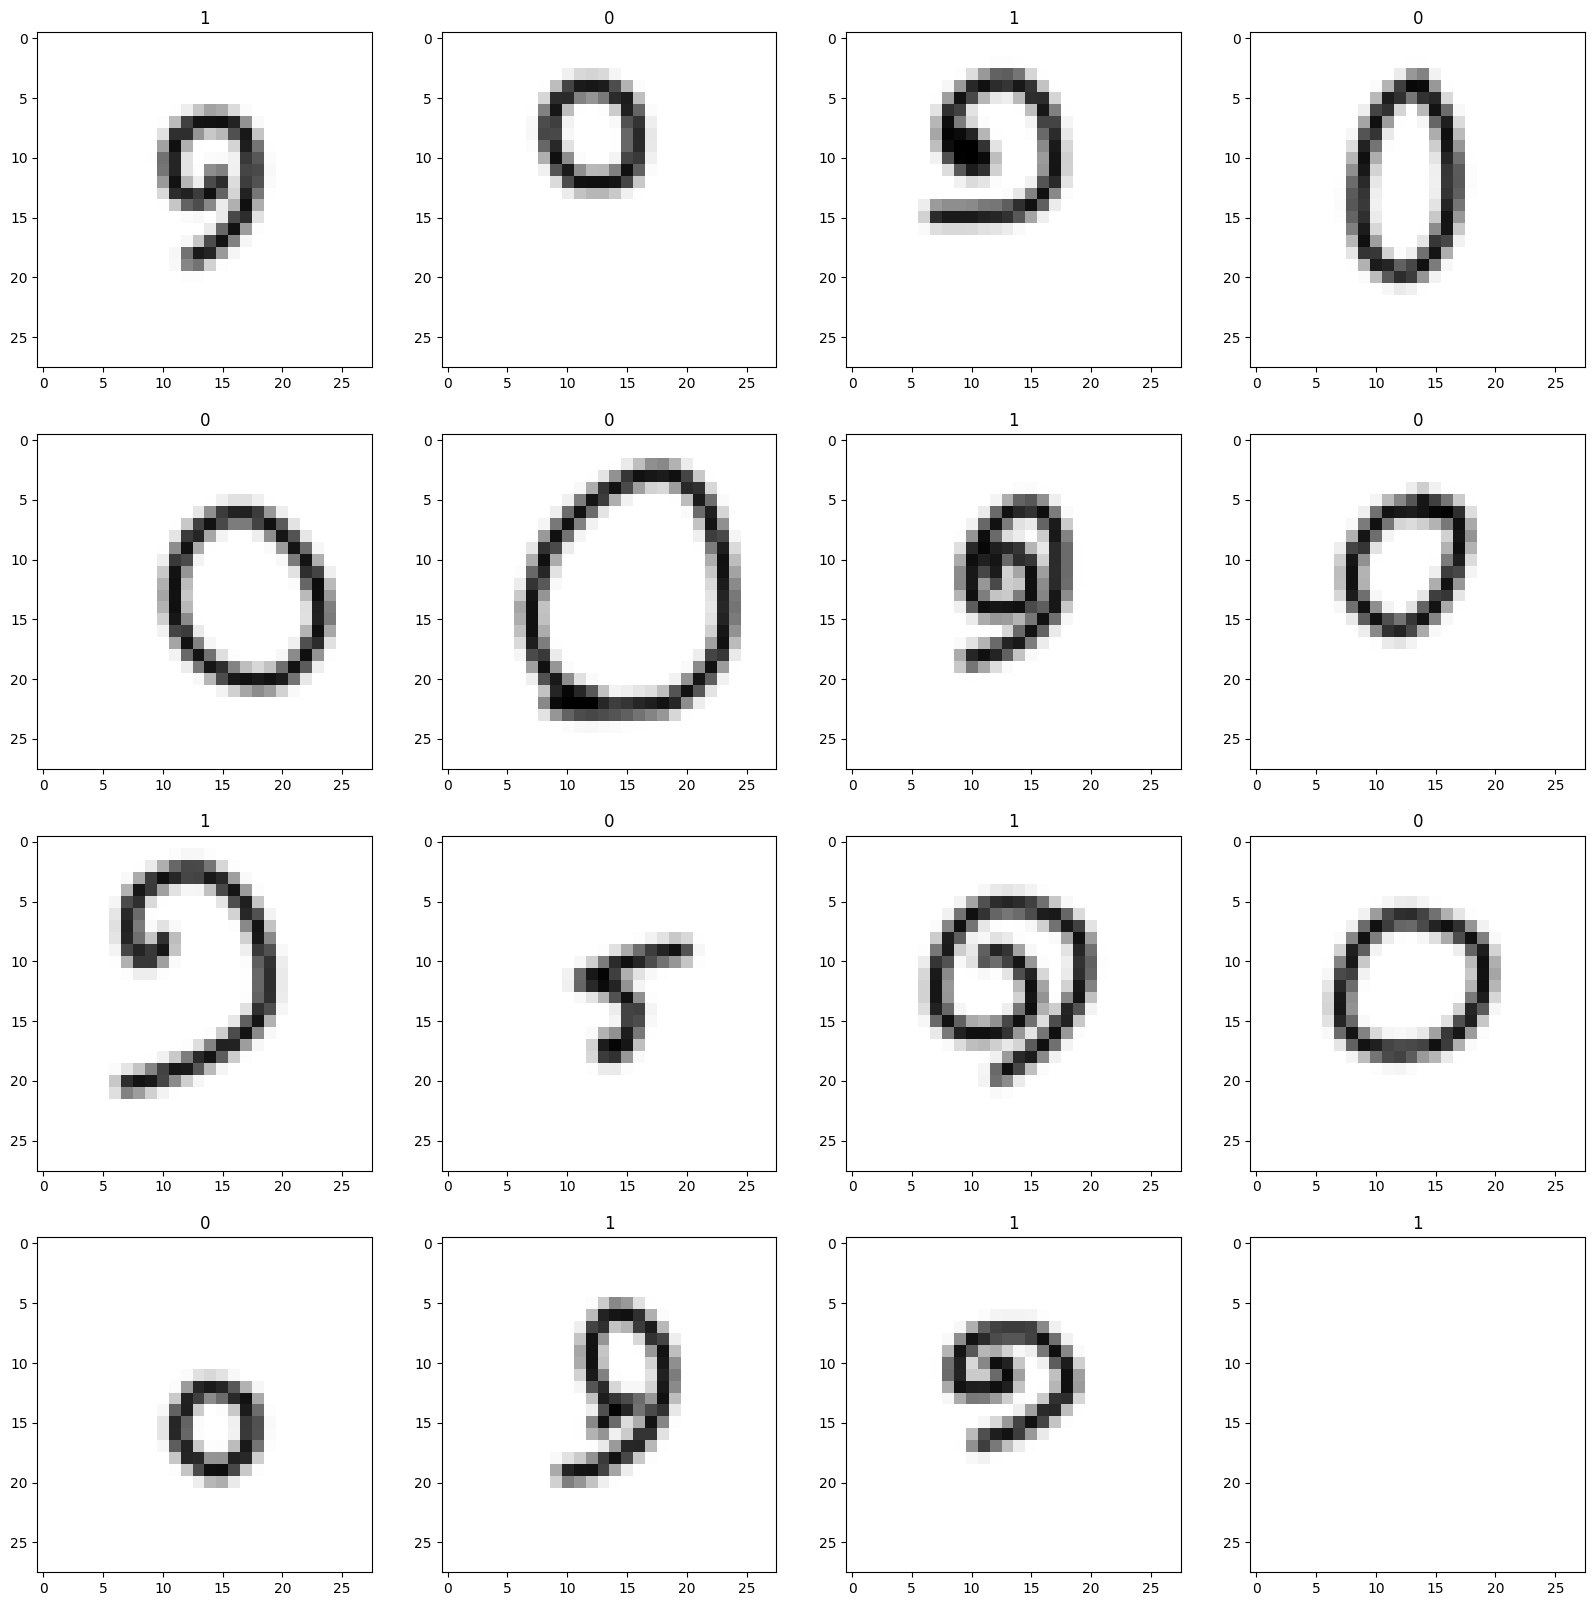

In [63]:
### START CODE HERE ###
class_names = ["0", "1"]
train_loader, test_loader = load_data("/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/thai-handwriting-number.appspot.com/", class_names)

fig = plt.figure(figsize=(20, 20))
train_features, train_labels = next(iter(train_loader))

axs = fig.subplots(4, 4)
i = 0
for img in train_features:
	row_index = i // 4
	column_index = i % 4
	img = np.transpose(img, (1, 2, 0))
	axs[row_index][column_index].set_title(str(train_labels[i].tolist()))
	axs[row_index][column_index].imshow(img, cmap="gray")
	i += 1


### END CODE HERE ###

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


In [75]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)  # RGB input, 3 channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

        # Define fully connected layers
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output 10 classes

        # Activation function
        self.relu = nn.ReLU()

        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Conv1 + ReLU
        x = F.max_pool2d(x, 2)        # Max pooling after conv1
        
        x = self.relu(self.conv2(x))  # Conv2 + ReLU
        x = F.max_pool2d(x, 2)        # Max pooling after conv2

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the output (batch_size, num_features)

        # Lazy initialization of fc1 to calculate input size dynamically
        if self.fc1 is None:
            num_features = x.shape[1]
            self.fc1 = nn.Linear(num_features, 120)

        # Fully connected layers
        x = self.relu(self.fc1(x))    # FC1 + ReLU
        x = self.relu(self.fc2(x))    # FC2 + ReLU
        x = self.fc3(x)  

        return x

### END CODE HERE ###



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [76]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
	### START CODE HERE ###
	# Move the model to the specified device (CPU or GPU)
	model = model.to(device)

	for epoch in range(epochs):
		# Training phase
		model.train()  # Set the model to training mode
		train_loss = 0.0
		correct_train = 0
		total_train = 0
		
		for images, labels in train_loader:
			images, labels = images.to(device), labels.to(device)
			
			# Zero the parameter gradients
			opt.zero_grad()
			
			# Forward pass
			outputs = model(images)
			loss = loss_fn(outputs, labels)
			train_loss += loss.item()

			# Backward pass and optimization
			loss.backward()
			opt.step()

			# Calculate training accuracy
			predicted = outputs.round()  # Round predictions to 0 or 1 for binary classification
			correct_train += (predicted == labels).sum().item()
			total_train += labels.size(0)
		
		# Calculate average training loss and accuracy
		avg_train_loss = train_loss / len(train_loader)
		train_accuracy = 100 * correct_train / total_train

		# Validation phase
		model.eval()  # Set the model to evaluation mode
		test_loss = 0.0
		correct_test = 0
		total_test = 0
		
		with torch.no_grad():  # No gradient calculation during evaluation
			for images, labels in test_loader:
				images, labels = images.to(device), labels.to(device)
				
				# Forward pass
				outputs = model(images)
				loss = loss_fn(outputs, labels)
				test_loss += loss.item()

				# Calculate validation accuracy
				predicted = outputs.round()
				correct_test += (predicted == labels).sum().item()
				total_test += labels.size(0)
		
		# Calculate average test loss and accuracy
		avg_test_loss = test_loss / len(test_loader)
		test_accuracy = 100 * correct_test / total_test

		# Log the results for this epoch
		print(f"Epoch [{epoch+1}/{epochs}]")
		print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
		print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

	# Save the model if a checkpoint path is provided
	if checkpoint_path:
		torch.save(model.state_dict(), checkpoint_path)
		print(f"Model saved to {checkpoint_path}")



	### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [78]:
### START CODE HERE ###
import torch.optim as optim

# Your CustomLeNet and load_data should already be defined

models = {
    'CustomLeNet': CustomLeNet(),
    # Add other models if applicable
}

# Example of hyperparameter combinations
combinations = [
    {'epochs': 10, 'batch_size': 32, 'lr': 0.001},
    {'epochs': 15, 'batch_size': 64, 'lr': 0.0005},
    # Add more combinations as needed
]

# Train each model with each combination of parameters
for model_name, model in models.items():
    for combo in combinations:
        print(f"Training {model_name} with epochs={combo['epochs']}, batch_size={combo['batch_size']}, lr={combo['lr']}")
        
        # Define your optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=combo['lr'])
        loss_fn = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

        # Update DataLoaders with specific batch size
        train_loader, test_loader = load_data("/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/thai-handwriting-number.appspot.com", ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

        # Move the model to the GPU if available
        device = torch.device('cpu')
        model = model.to(device)

        # Train the model
        train(model, optimizer, loss_fn, train_loader, test_loader, epochs=combo['epochs'], device=device)

        # Optionally save the model for this combination
        model_save_path = f"model_{model_name}_epochs{combo['epochs']}_batch{combo['batch_size']}_lr{combo['lr']}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved as {model_save_path}\n")
### END CODE HERE ###

Training CustomLeNet with epochs=10, batch_size=32, lr=0.001
Train Dataset:
Number of images in class 9: 316
Number of images in class 6: 300
Number of images in class 7: 311
Number of images in class 4: 302
Number of images in class 0: 307
Number of images in class 8: 321
Number of images in class 5: 308
Number of images in class 2: 313
Number of images in class 3: 318
Number of images in class 1: 309
Number of training samples: 3105

Test Dataset:
Number of images in class 3: 70
Number of images in class 1: 80
Number of images in class 0: 81
Number of images in class 6: 88
Number of images in class 8: 67
Number of images in class 2: 76
Number of images in class 4: 86
Number of images in class 9: 72
Number of images in class 7: 77
Number of images in class 5: 80
Number of testing samples: 777


RuntimeError: The size of tensor a (10) must match the size of tensor b (16) at non-singleton dimension 1

Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


In [ ]:
### START CODE HERE ###





### END CODE HERE ###

Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

In [ ]:
### START CODE HERE ###





### END CODE HERE ###

---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.
